In [129]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns



## Load data

In [130]:
#Loading the pre processed data
df=pd.read_csv("Clustering_dataset_1.csv")
print("Dataset Loaded Successfully!")
print(df.head())

Dataset Loaded Successfully!
     ID   Education Marital_Status   Income  Kidhome  Teenhome Dt_Customer  \
0  5524  Graduation         Single  58138.0        0         0  04-09-2012   
1  2174  Graduation         Single  46344.0        1         1  08-03-2014   
2  4141  Graduation       Together  71613.0        0         0  21-08-2013   
3  6182  Graduation       Together  26646.0        1         0  10-02-2014   
4  5324         PhD        Married  58293.0        1         0  19-01-2014   

   Recency  MntWines  MntFruits  ...  AcceptedCmp2  Complain  Z_CostContact  \
0       58       635         88  ...             0         0              3   
1       38        11          1  ...             0         0              3   
2       26       426         49  ...             0         0              3   
3       26        11          4  ...             0         0              3   
4       94       173         43  ...             0         0              3   

   Z_Revenue  Response  Age

## K-mean implementation

In [131]:
def initialize_centroids(X,k):
    np.random.seed(42)  #ensures we get the same centroid each time we run it
    random_indices=np.random.choice(X.shape[0],k,replace=False)  #randomly pics k unique row indices from the dataset
    return X[random_indices]

def assign_clusters(X,centroids):
    distances=np.sqrt(((X-centroids[:,np.newaxis])**2).sum(axis=2))  #(X - centroids[:, np.newaxis])**2: Computes the squared diff between each centroid and data point. Sum(axis=2) sums the squared diff across all features (euclidean here)
    return np.argmin(distances,axis=0) #argmin to find the closest centroid

def update_centroids(X,labels,k):
    return np.array([X[labels==i].mean(axis=0) for i in range(k)])  #label=i means select all point belonging to cluster i and compute the mean of all of them to find the new centroid

def kmeans(X,k,max_iters=100,tol=1e-4):
    centroids=initialize_centroids(X,k)  #initialize centroids randomly first
    for i in range(max_iters):
        labels=assign_clusters(X,centroids)
        new_centroids=update_centroids(X,labels,k)
        if np.all(np.abs(new_centroids-centroids)<tol): #if the centroids dont move much stop
            break
        centroids=new_centroids

    return labels,centroids

## Compute inertia

In [132]:
def compute_inertia(X, labels, centroids):
    distances = np.min(np.sqrt(((X - centroids[:, np.newaxis])**2).sum(axis=2)), axis=0)
    return np.sum(distances**2)

## Compute Elbow+Silhouette Scores

In [133]:

def evaluate_k_values(X_scaled, k_list):
    inertias = []
    silhouettes = []

    print("\nEvaluating K values...\n")
    for k in k_list:
        labels, centroids = kmeans(X_scaled, k)
        inertia = compute_inertia(X_scaled, labels, centroids)
        sil = silhouette_score(X_scaled, labels)

        inertias.append(inertia)
        silhouettes.append(sil)

        print(f"K={k} | Inertia={inertia:.2f} | Silhouette={sil:.4f}")

    return inertias, silhouettes

def plot_metrics(k_list, inertias, silhouettes):
    plt.figure(figsize=(6,4))
    plt.plot(k_list, inertias, '-o')
    plt.title("Elbow Method")
    plt.xlabel("k")
    plt.ylabel("Inertia")
    plt.grid(True)
    plt.show()

    plt.figure(figsize=(6,4))
    plt.plot(k_list, silhouettes, '-o', color='orange')
    plt.title("Silhouette Scores")
    plt.xlabel("k")
    plt.ylabel("Silhouette Score")
    plt.grid(True)
    plt.show()

## Final cluster visualization + PLA plot

In [146]:
def final_clustering(X_scaled, df, k):
    labels, centroids = kmeans(X_scaled, k)

    df["Cluster"] = labels

    pca = PCA(n_components=2)
    components = pca.fit_transform(X_scaled)

    df_plot = pd.DataFrame(components, columns=["PC1", "PC2"])
    df_plot["Cluster"] = labels

    plt.figure(figsize=(8,6))
    sns.scatterplot(data=df_plot, x="PC1", y="PC2", hue="Cluster", palette="tab10")
    plt.title(f"K-Means Clusters for k={k} (PCA Reduced)")
    plt.show()

    print("\nCluster Means:")
    print(df.groupby("Cluster").mean())

    return labels


## 1. Customer demographics
Age, Income, Children_in_family, Marital Status

In [147]:
features = ['Age', 'Income', 'Children_in_family', 'Marital_Status']
X = df[features].copy()


In [148]:
X

,Age,Income,Children_in_family,Marital_Status
0,68,58138.0,0,Single
1,71,46344.0,2,Single
2,60,71613.0,0,Together
3,41,26646.0,1,Together
4,44,58293.0,1,Married
...,...,...,...,...
2235,58,61223.0,1,Married
2236,79,64014.0,3,Together
2237,44,56981.0,0,Divorced
2238,69,69245.0,1,Together



Evaluating K values...

K=2 | Inertia=19989.47 | Silhouette=0.4515
K=5 | Inertia=11107.68 | Silhouette=0.4568
K=7 | Inertia=10472.63 | Silhouette=0.4075
K=9 | Inertia=9227.23 | Silhouette=0.3232


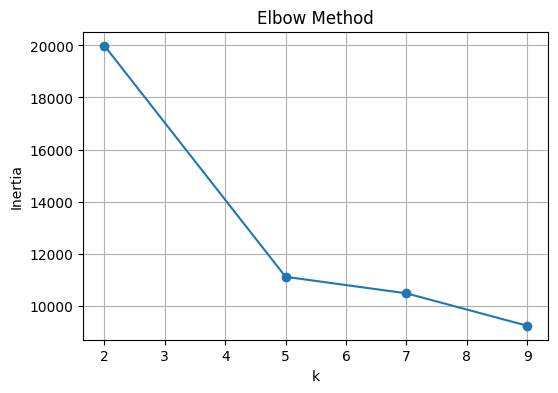

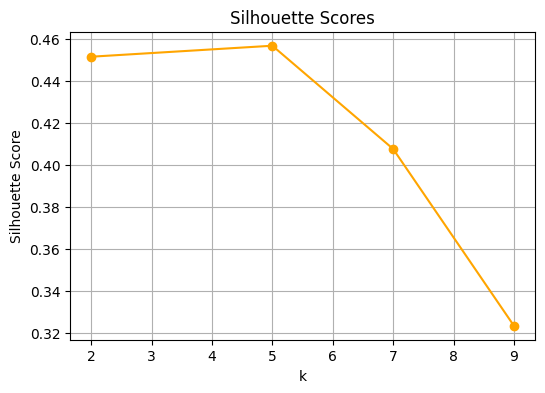

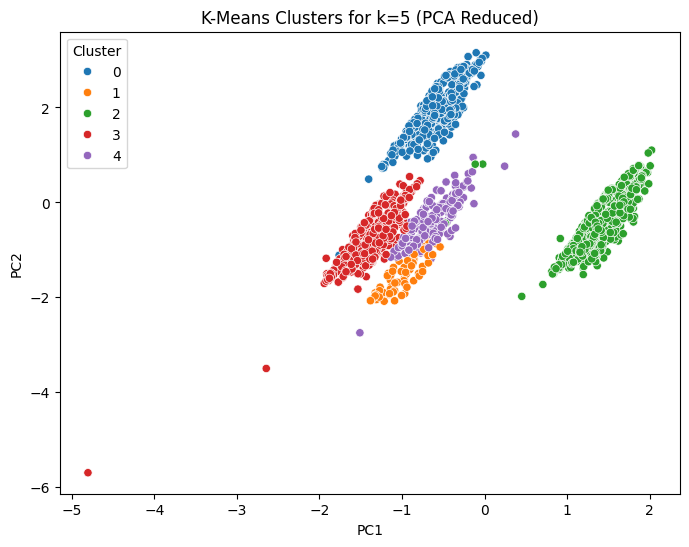


Cluster Means:
                  ID        Income   Kidhome  Teenhome    Recency    MntWines  \
Cluster                                                                         
0        5489.241667  51002.590625  0.464583  0.406250  49.506250  288.331250   
1        5969.558442  56415.318182  0.233766  0.636364  49.142857  369.272727   
2        5634.529954  51762.180300  0.453917  0.511521  48.184332  299.661290   
3        5644.674138  53223.037069  0.450000  0.529310  50.106897  306.825862   
4        5392.608511  52718.757447  0.421277  0.591489  49.242553  323.055319   

         MntFruits  MntMeatProducts  MntFishProducts  MntSweetProducts  ...  \
Cluster                                                                 ...   
0        26.835417       182.108333        38.216667         27.262500  ...   
1        33.090909       189.285714        51.389610         39.012987  ...   
2        25.817972       160.776498        35.700461         26.655530  ...   
3        25.350000   

/tmp/ipykernel_10362/3862349715.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  print(df.groupby("Cluster").mean())


In [149]:
# One-hot encode marital status
X = pd.get_dummies(X, columns=['Marital_Status'], drop_first=True)

# Scale features
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# -----------------------------------------------------
# ELBOW METHOD + SILHOUETTE SCORE
# -----------------------------------------------------
k_list = [2, 5, 7, 9]
inertias, silhouettes = evaluate_k_values(X_scaled, k_list)
plot_metrics(k_list, inertias, silhouettes)

# --------------------------------------------
# FINAL CLUSTERING (CHOOSE BEST k)
# --------------------------------------------
best_k = 5
final_labels = final_clustering(X_scaled, df, best_k)


In [168]:
# Analyzing PCA
print("PCA components shape:", pca.components_.shape)
print("PCA components.T shape:", pca.components_.T.shape)
print("Number of X columns:", len(X.columns))
print(X.columns)

X = df[['Age', 'Income', 'Children_in_family', 'Marital_Status']]
X = pd.get_dummies(Y, columns=['Marital_Status'], drop_first=True)

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=2)
pca.fit(X_scaled)
loadings = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2'],
    index=X.columns
)

print(loadings)



PCA components shape: (2, 5)
PCA components.T shape: (5, 2)
Number of X columns: 4
Index(['Age', 'Income', 'Children_in_family', 'Marital_Status'], dtype='object')
                              PC1       PC2
Age                     -0.177816 -0.454656
Income                  -0.146700 -0.217314
Children_in_family       0.074829 -0.070504
Marital_Status_Alone     0.003974  0.019244
Marital_Status_Divorced -0.139448 -0.091412
Marital_Status_Married   0.769486 -0.215300
Marital_Status_Single   -0.191812  0.740265
Marital_Status_Together -0.526975 -0.306856
Marital_Status_Widow    -0.123254 -0.208696
Marital_Status_YOLO     -0.002218  0.017435


## 2.Customer spending and recency 

In [154]:
features = [
    'Age', 
    'Income', 
    'Recency', 
    'Total_spending',
    'Total_Num_Columns'
]
Y = df[features].copy()

# Scaling
scaler = StandardScaler()
Y_scaled = scaler.fit_transform(Y)

# Run evaluation on k values
k_list = [2, 5, 7, 9]
inertias, silhouettes = evaluate_k_values(Y_scaled, k_list)


Evaluating K values...

K=2 | Inertia=7054.52 | Silhouette=0.3463
K=5 | Inertia=4831.90 | Silhouette=0.2338
K=7 | Inertia=4093.30 | Silhouette=0.2333
K=9 | Inertia=3673.01 | Silhouette=0.2269


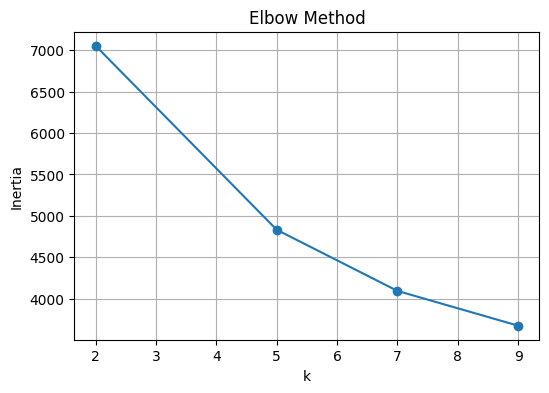

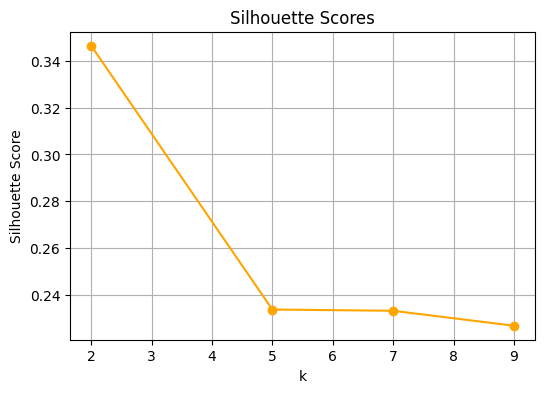

In [155]:
# Plot elbow + silhouette
plot_metrics(k_list, inertias, silhouettes)

Silhoutte score is more important criteria lets choose k=2

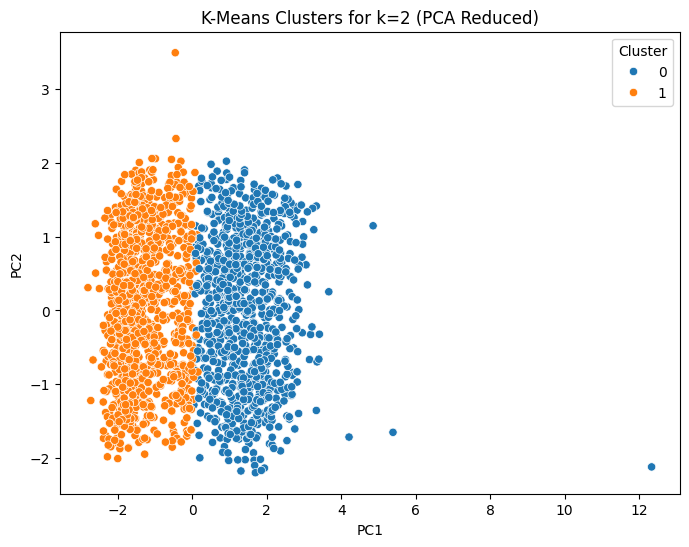


Cluster Means:
                  ID        Income   Kidhome  Teenhome    Recency    MntWines  \
Cluster                                                                         
0        5573.255218  70258.112903  0.132827  0.518975  49.461101  577.963947   
1        5608.960371  36223.451939  0.720911  0.494941  48.796796   60.406408   

         MntFruits  MntMeatProducts  MntFishProducts  MntSweetProducts  ...  \
Cluster                                                                 ...   
0        48.375712        319.20778        68.977230         50.320683  ...   
1         6.685497         31.63828         9.574199          6.393761  ...   

         AcceptedCmp2  Complain  Z_CostContact  Z_Revenue  Response  \
Cluster                                                               
0            0.026565  0.007590            3.0       11.0  0.210626   
1            0.001686  0.010961            3.0       11.0  0.094435   

               Age  Total_spending  Total_Num_Columns  Ch

/tmp/ipykernel_10362/3862349715.py:18: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  print(df.groupby("Cluster").mean())


array([0, 1, 0, ..., 0, 0, 1])

In [157]:
# Run final clustering
final_clustering(X_scaled, df, 2)

## Analyzing PCA

In [163]:
print("PCA components shape:", pca.components_.shape)
print("PCA components.T shape:", pca.components_.T.shape)
print("Number of X columns:", len(X.columns))
print(X.columns)

Y = df[['Age', 'Income', 'Recency', 'Total_spending', 'Total_Num_Columns']]
scaler = StandardScaler()
Y_scaled = scaler.fit_transform(Y)
pca = PCA(n_components=2)
pca.fit(Y_scaled)
loadings = pd.DataFrame(
    pca.components_.T,
    columns=['PC1', 'PC2'],
    index=X.columns
)

print(loadings)



PCA components shape: (2, 10)
PCA components.T shape: (10, 2)
Number of X columns: 5
Index(['Age', 'Income', 'Recency', 'Total_spending', 'Total_Num_Columns'], dtype='object')
                        PC1       PC2
Age                0.181597  0.305290
Income             0.541693 -0.045111
Recency            0.012213  0.949750
Total_spending     0.590702 -0.041899
Total_Num_Columns  0.569661 -0.031340
